#### Chris Sutton 
#### EN.525.733.VL2
#### HW 7


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import nn as nn

import random
from PIL import Image
import PIL.ImageOps    
import torchvision.utils
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
import torch.nn.functional as F
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Download training data from open datasets.
training_d = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

train_data, valid_data = random_split(training_d,[45000,5000])

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
# valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64)

100%|██████████| 170498071/170498071 [00:12<00:00, 13127437.25it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset    
              
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset) #.imgs

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
               
                img1_tuple = random.choice(self.imageFolderDataset) #.imgs
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:            
                img1_tuple = random.choice(self.imageFolderDataset) #.imgs
                if img0_tuple[1] != img1_tuple[1]:
                    break
        img0 = img0_tuple[0]
        img1 = img1_tuple[0]

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset)

In [ ]:
# Initialize the data
siamese_dataset_train = SiameseNetworkDataset(imageFolderDataset=train_data)
siamese_dataset_dev = SiameseNetworkDataset(imageFolderDataset=train_data)
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=test_data)

In [ ]:
train_dataloader = DataLoader(siamese_dataset_train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(siamese_dataset_dev, batch_size=64, shuffle=True)
test_dataloader = DataLoader(siamese_dataset_test, batch_size=1)

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.layer1_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer1_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.layer2_1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer2_2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.layer3_1 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer3_2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer3_3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.layer4_1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer4_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer4_3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.layer5_1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer5_2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer5_3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2))
        self.fc1 = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU())
        
    def forward_once(self, x):
        #called for both images
        output = self.layer1_1(x)
        output = self.layer1_2(output)
        output = self.layer2_1(output)
        output = self.layer2_2(output)
        output = self.layer3_1(output)
        output = self.layer3_2(output)
        output = self.layer3_3(output)
        output = self.layer4_1(output)
        output = self.layer4_2(output)
        output = self.layer4_3(output)
        output = self.layer5_1(output)
        output = self.layer5_2(output)
        output = self.layer5_3(output)
        output = output.reshape(output.size(0), -1)
        # print("out from layer0" , x.size())
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output

    def forward(self, input1, input2):
        # pass in both images and obtain both vector
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
# euclidian distance
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
# calculate the contrastive loss
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
# set variables 
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [ ]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Streaming output truncated to the last 5000 lines.
 Current loss 0.078367680311203

Epoch number 76
 Current loss 0.007603426463901997

Epoch number 76
 Current loss 0.0028128898702561855

Epoch number 76
 Current loss 0.008062569424510002

Epoch number 76
 Current loss 0.010693678632378578

Epoch number 76
 Current loss 0.011526504531502724

Epoch number 76
 Current loss 0.017701826989650726

Epoch number 76
 Current loss 0.0080143753439188

Epoch number 76
 Current loss 0.07510477304458618

Epoch number 76
 Current loss 0.00207442045211792

Epoch number 76
 Current loss 0.008919741027057171

Epoch number 76
 Current loss 0.1329556703567505

Epoch number 76
 Current loss 0.04481849446892738

Epoch number 76
 Current loss 0.0034280926920473576

Epoch number 76
 Current loss 0.001330157509073615

Epoch number 76
 Current loss 0.009615454822778702

Epoch number 76
 Current loss 0.0026809500996023417

Epoch number 76
 Current loss 0.038320835679769516

Epoch number 76
 Current loss 0.0117

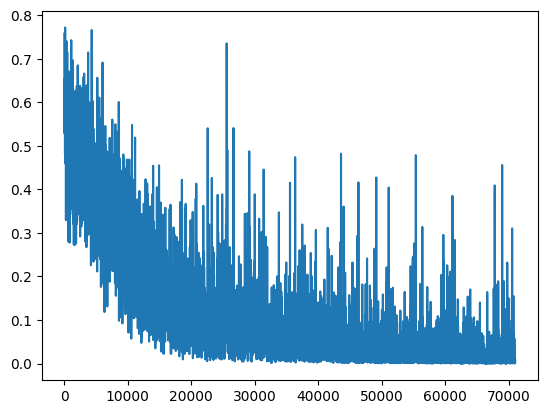

In [ ]:
# train
img0_labels=[]
img1_labels=[]
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)
        
        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())


plt.plot(counter,loss_history)
plt.show()

In [ ]:
all_preds=[]
all_labels=[]
with torch.no_grad():
   for i, (img0, img1, label) in enumerate(test_dataloader, 0):
      all_labels.append(label[0][0])
      # Concatenate the two images together
      # concatenated = torch.cat((x0, x1), 0)
      
      output1, output2 = net(img0.to(device), img1.to(device))
      euclidean_distance = F.pairwise_distance(output1, output2)
      if euclidean_distance.item()<= 2:
        all_preds.append(0 )
      else:
        all_preds.append( 1 )

      # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')


[[3776 1146]
 [1232 3846]]


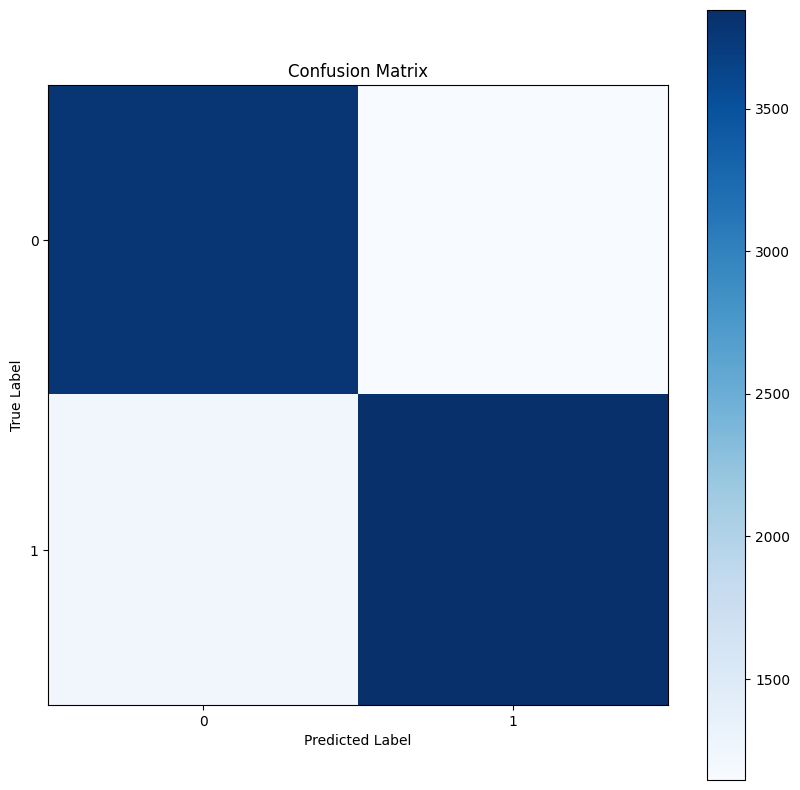

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(cm)
# for x, y in zip(all_labels, all_preds):
#   print(x,y)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 100 Epochs,  margin = 2,  accuracy 76.2%

# 20 epochs , margin =1.5 , accuracy 68.5 % 

# 12 epochs . margin 1, accuracy 65.6%